### Main steps
* step 01 - load data
* step 02 - compare UID and images
* step 03 - save with new according to YOLO V5 format
* step 04 - input downloaded images to YOLOV5

### Load data from dataset and compare UID and Images

In [3]:
import pandas as pd
import pydicom as pdc
import os
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import json

# Load the CSV file with annotations
annotations_csv = r"C:\Users\MSII\Documents\sem 5\image processing\project\brain-hemorrhage-extended-bhx-bounding-box-extrapolation-from-thick-to-thin-slice-ct-images-1.1\3_Extrapolation_to_Selected_Series.csv" 
annotations_df = pd.read_csv(annotations_csv)

# Directory containing DICOM images from the CQ500 dataset
dicom_dir = r"C:\Users\MSII\Documents\sem 5\image processing\project\CQ500_Dataset\aria2-1.36\CQ500CT0 CQ500CT0\Unknown Study\CT PLAIN THIN"
# Create a dictionary to map SOP Instance UIDs to DICOM file paths
uid_path_data = {}
for root, dirs, files in os.walk(dicom_dir):
    print(dirs)
    for file in files:
        
        if file.endswith(".dcm"):
            dicom_file_path = os.path.join(root, file)
            dicom_image = pdc.dcmread(dicom_file_path)
            sop_uid = dicom_image.SOPInstanceUID
            uid_path_data[sop_uid] = [dicom_file_path]

i = 0            
image_label_mapping = {}
for index, row in annotations_df.iterrows():
    if row['SOPInstanceUID'] in uid_path_data:
        uid_path_data[row['SOPInstanceUID']].append(row)
        print(uid_path_data[row['SOPInstanceUID']][0])
        i += 1
print(i, 'No of images were saved')

[]
C:\Users\MSII\Documents\sem 5\image processing\project\CQ500_Dataset\aria2-1.36\CQ500CT0 CQ500CT0\Unknown Study\CT PLAIN THIN\CT000072.dcm
C:\Users\MSII\Documents\sem 5\image processing\project\CQ500_Dataset\aria2-1.36\CQ500CT0 CQ500CT0\Unknown Study\CT PLAIN THIN\CT000179.dcm
C:\Users\MSII\Documents\sem 5\image processing\project\CQ500_Dataset\aria2-1.36\CQ500CT0 CQ500CT0\Unknown Study\CT PLAIN THIN\CT000073.dcm
C:\Users\MSII\Documents\sem 5\image processing\project\CQ500_Dataset\aria2-1.36\CQ500CT0 CQ500CT0\Unknown Study\CT PLAIN THIN\CT000166.dcm
C:\Users\MSII\Documents\sem 5\image processing\project\CQ500_Dataset\aria2-1.36\CQ500CT0 CQ500CT0\Unknown Study\CT PLAIN THIN\CT000183.dcm
C:\Users\MSII\Documents\sem 5\image processing\project\CQ500_Dataset\aria2-1.36\CQ500CT0 CQ500CT0\Unknown Study\CT PLAIN THIN\CT000183.dcm
C:\Users\MSII\Documents\sem 5\image processing\project\CQ500_Dataset\aria2-1.36\CQ500CT0 CQ500CT0\Unknown Study\CT PLAIN THIN\CT000182.dcm
C:\Users\MSII\Documents\

### Pre processing the image array 

In [4]:
import numpy as np
import cv2 as cv
import SimpleITK as sitk
import matplotlib.pyplot as plt
from PIL import Image

def pre_process_im_arr(image_array):
    # Define window levels and widths for brain tissue
    window_level = 40  # Adjust this value based on your data
    window_width = 80  # Adjust this value based on your data

    # Apply windowing to the CT scan
    min_value = window_level - window_width / 2   # 0
    max_value = window_level + window_width / 2   # 80
    image_array[image_array < min_value] = min_value
    image_array[image_array > max_value] = max_value

    # Normalize the HU values to the range [0, 255]
    image_array = ((image_array - min_value) / (max_value - min_value) * 255).astype(np.uint8)

    # Apply morphology dilation to remove noise
    kernel = np.ones((3, 3), np.uint8)  # Adjust the kernel size as needed
    return cv.dilate(image_array, kernel, iterations=1).squeeze()

im_array = {}
for key, item in uid_path_data.items():
    if len(item) > 1:
        print(item[0])
        ct_image = sitk.GetArrayFromImage(sitk.ReadImage(item[0]))
        im_array[key] = pre_process_im_arr(ct_image)
print(len(im_array), "images were preprocessed")

C:\Users\MSII\Documents\sem 5\image processing\project\CQ500_Dataset\aria2-1.36\CQ500CT0 CQ500CT0\Unknown Study\CT PLAIN THIN\CT000007.dcm
C:\Users\MSII\Documents\sem 5\image processing\project\CQ500_Dataset\aria2-1.36\CQ500CT0 CQ500CT0\Unknown Study\CT PLAIN THIN\CT000010.dcm
C:\Users\MSII\Documents\sem 5\image processing\project\CQ500_Dataset\aria2-1.36\CQ500CT0 CQ500CT0\Unknown Study\CT PLAIN THIN\CT000032.dcm
C:\Users\MSII\Documents\sem 5\image processing\project\CQ500_Dataset\aria2-1.36\CQ500CT0 CQ500CT0\Unknown Study\CT PLAIN THIN\CT000047.dcm
C:\Users\MSII\Documents\sem 5\image processing\project\CQ500_Dataset\aria2-1.36\CQ500CT0 CQ500CT0\Unknown Study\CT PLAIN THIN\CT000055.dcm
C:\Users\MSII\Documents\sem 5\image processing\project\CQ500_Dataset\aria2-1.36\CQ500CT0 CQ500CT0\Unknown Study\CT PLAIN THIN\CT000061.dcm
C:\Users\MSII\Documents\sem 5\image processing\project\CQ500_Dataset\aria2-1.36\CQ500CT0 CQ500CT0\Unknown Study\CT PLAIN THIN\CT000062.dcm
C:\Users\MSII\Documents\sem

### Save the dataset in Yolo format

In [13]:
import cv2 as cv
import os 
import random

items = list(im_array.items())
random.shuffle(items)
split_point = int((len(items)/10)*9)

# Divide the list into two subsets
Train = dict(items[:split_point])
val = dict(items[split_point:])
print("total {} images were preprocessed.\n".format(len(im_array)))
print("Train set ------> {} elements.".format(len(Train)))
print("Validate set ------> {} elements. \n".format(len(val)))

main_dir = r'C:/Users/MSII/Documents/sem 5/image processing/project/preprocessed_Output'
dir = {"train image": r"train/images", "val image": r"val/images",
       "train label": r"train/label", "val label": r"val/label"}
# Ensure the output directory exists, or create it
for key in dir:
    data_path = os.path.join(main_dir, dir[key])
    if not os.path.exists(data_path):
        os.makedirs(data_path)
        
# Loop through the pre-processed images in image_array and save them as JPG

def save_image(data, path):
    j=0
    for i,val in data.items():
        img_dir = os.path.join(path, f"{i}.jpg")
        cv.imwrite(img_dir, val)
        j+=1
    print(f"{j} pre-processed images saved as JPG in {path}")
    return
#train images
save_image(Train, os.path.join(main_dir, dir["train image"])) 
#val images
save_image(val, os.path.join(main_dir, dir["val image"])) 

total 15967 images were preprocessed.

Train set ------> 14370 elements.
Validate set ------> 1597 elements. 

14370 pre-processed images saved as JPG in C:/Users/MSII/Documents/sem 5/image processing/project/preprocessed_Output\train/images
1597 pre-processed images saved as JPG in C:/Users/MSII/Documents/sem 5/image processing/project/preprocessed_Output\val/images


#### Save labels

(512, 512)
1.2.276.0.7230010.3.1.4.296485376.1.1521714313.2033604
['C:\\Users\\MSII\\Documents\\sem 5\\image processing\\project\\CQ500_Dataset\\aria2-1.36\\CQ500CT0 CQ500CT0\\Unknown Study\\CT PLAIN THIN\\CT000007.dcm', Unnamed: 0                                                       28324
SOPInstanceUID       1.2.276.0.7230010.3.1.4.296485376.1.1521714313...
SeriesInstanceUID    1.2.276.0.7230010.3.1.3.296485376.1.1521714313...
StudyInstanceUID     1.2.276.0.7230010.3.1.2.296485376.1.1521714307...
data                 {'x': 182.61706999999998, 'y': 265.07484, 'wid...
labelName                                                 Subarachnoid
labelType                                           selectedThinSlices
Name: 18792, dtype: object]


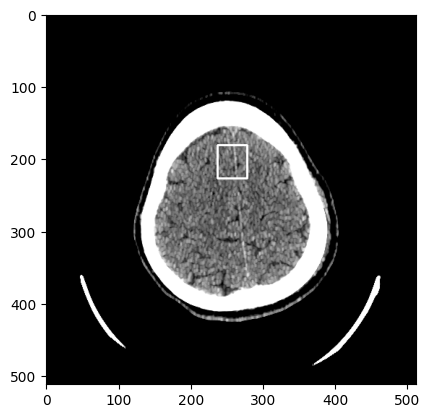

In [8]:
import json

for k in im_array:
    im = im_array[k]
    sop = k
    break
cv.rectangle(im, (int(237.96629),int(181.93258)),(int(237.96629+40.98875),int(181.93258+46.02248)),(255,0,0), 2 )
# fig, ax = plt.subplots(1,2)
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))
# ax[1].imshow(im)
print(im.shape)
print(k)
print(uid_path_data[k])

# print(json_str)

In [15]:
# import os
# label_dir = os.path.join(dir['train label'], f"{1}.txt")
# # Open a file in write mode (creates a new file if it doesn't exist, and truncates the file if it does)
# with open(label_dir, 'w') as file:
#     file.write('This is {} the first line.\n'.format("ses"))
#     file.write('This is the second line.\n')
#     file.write('This is the third line.\n')
# with open(label_dir, 'w') as file:
#     file.write('This is {} the first line.\n'.format("ses"))
# print("File 'example.txt' has been created and saved.")

    

### Preprocessing label data for saving

In [16]:
labels = {'Intraventricular':0, 'Intraparenchymal':1, 'Subarachnoid':2, 'Chronic':3, 
          'Subdural':4, 'Epidural':5}
k=0
l=0
for i in uid_path_data:
    if i in Train:
        label_dir = os.path.join(os.path.join(main_dir, dir["train label"]), f"{i}.txt")
        l+=1
        
        with open(label_dir, 'w') as file:
            for j in range(1,len(uid_path_data[i])):
                box = uid_path_data[i][j]['data'].replace("'", "\"")
                box_dic = json.loads(box)
                x=(box_dic['x']+box_dic['width']/2)/512
                y=(box_dic['y']+box_dic['height']/2)/512
                w=box_dic['width']/512
                h=box_dic['height']/512
                label = uid_path_data[i][j]['labelName']
                file.write('{} {} {} {} {}\n'.format(labels[label], x,y,w,h))
        
    elif i in val:
        label_dir = os.path.join(os.path.join(main_dir, dir["val label"]), f"{i}.txt")
        k+=1  
        
        with open(label_dir, 'w') as file:
            for j in range(1,len(uid_path_data[i])):
                box = uid_path_data[i][j]['data'].replace("'", "\"")
                box_dic = json.loads(box)
                x=(box_dic['x']+box_dic['width']/2)/512
                y=(box_dic['y']+box_dic['height']/2)/512
                w=box_dic['width']/512
                h=box_dic['height']/512
                label = uid_path_data[i][j]['labelName']
                file.write('{} {} {} {} {}\n'.format(labels[label], x,y,w,h))
    
            
print("{} files were saved in {}".format(k,dir['val label']))
print("{} files were saved in {}".format(l,dir['train label']))

1597 files were saved in val/label
14370 files were saved in train/label
